In [1]:
import os
from IPython.display import display

# ROOT contais the project directory 
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from src.plots import plot_color_bar
from src.Fundus import Fundus
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from tqdm import tqdm
import torch

import PIL
from PIL import Image

In [3]:
def cluster(x):
    out = []
    # Iterate each row
    for i in tqdm(range(len(x))):
        if i-1 < 0:
            out.append(torch.mean(x[i:i+2], dim=0))

        elif i+1 < len(x):
            frame = torch.stack([x[i-1], x[i+1]]).to("cuda")
            diffs = torch.stack([ abs(x[i]-x[i-1]), abs(x[i]-x[i+1])])
            index = torch.min(diffs, dim=0).indices[:,0]
            minvl = torch.stack([frame[j,i,:] for i,j in enumerate(index)])
            out.append(torch.mean(torch.stack([minvl, x[i]]), dim=0))

        else:
            out.append(torch.mean(x[i-1:i+1], dim=0))
    # Stack 
    out = torch.stack(out, dim=0)
    
    return out.type(torch.uint8)


def cluste_transpose(func):
    x = torch.transpose(x, 0, 1)
    x = cluster(x)
    return torch.transpose(x, 0, 1)


def nearest_neighbour_mean(x):
    x = torch.cuda.HalfTensor(x)

    # Run clustering on data
    meaned_v = cluster(x)
    meaned_h = cluster_transpose(x)
    
    # Differrence between original and meaned
    diff_v = x - meaned_v
    diff_h = x - meaned_h
    diff = abs(diff_h) > abs(diff_v)
    
    # Propate flags
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            diff[i,j,:]=diff[i,j,0]
    
    diff2cal = torch.where(diff, meaned_v,meaned_h)
    
    return diff2cal

In [24]:
original = Fundus("data/noma/male_extra_0.png")
len(original.palette)

# Cluster pixels
modified = original.cluster_pixels_torch(1000)

100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


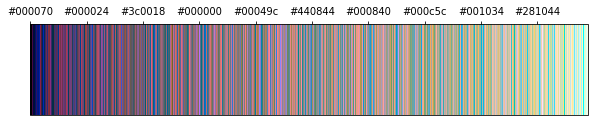

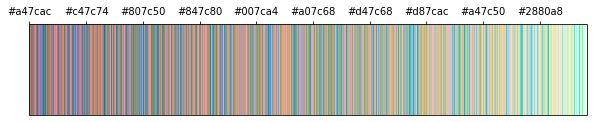

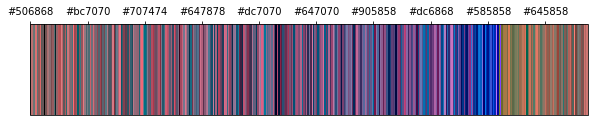

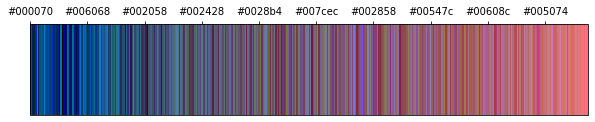

In [54]:
# Sort palette by G value
toplot = modified.palette[np.argsort(modified.palette[:,1])]
plot_color_bar(toplot)
toremove = toplot[400:,:]
tokeep = toplot[:400,:]
plot_color_bar(toremove)
plot_color_bar(tokeep[np.argsort(np.diff(tokeep[:,1:3]).flatten())])
plot_color_bar(tokeep[np.argsort(tokeep[:,0])])

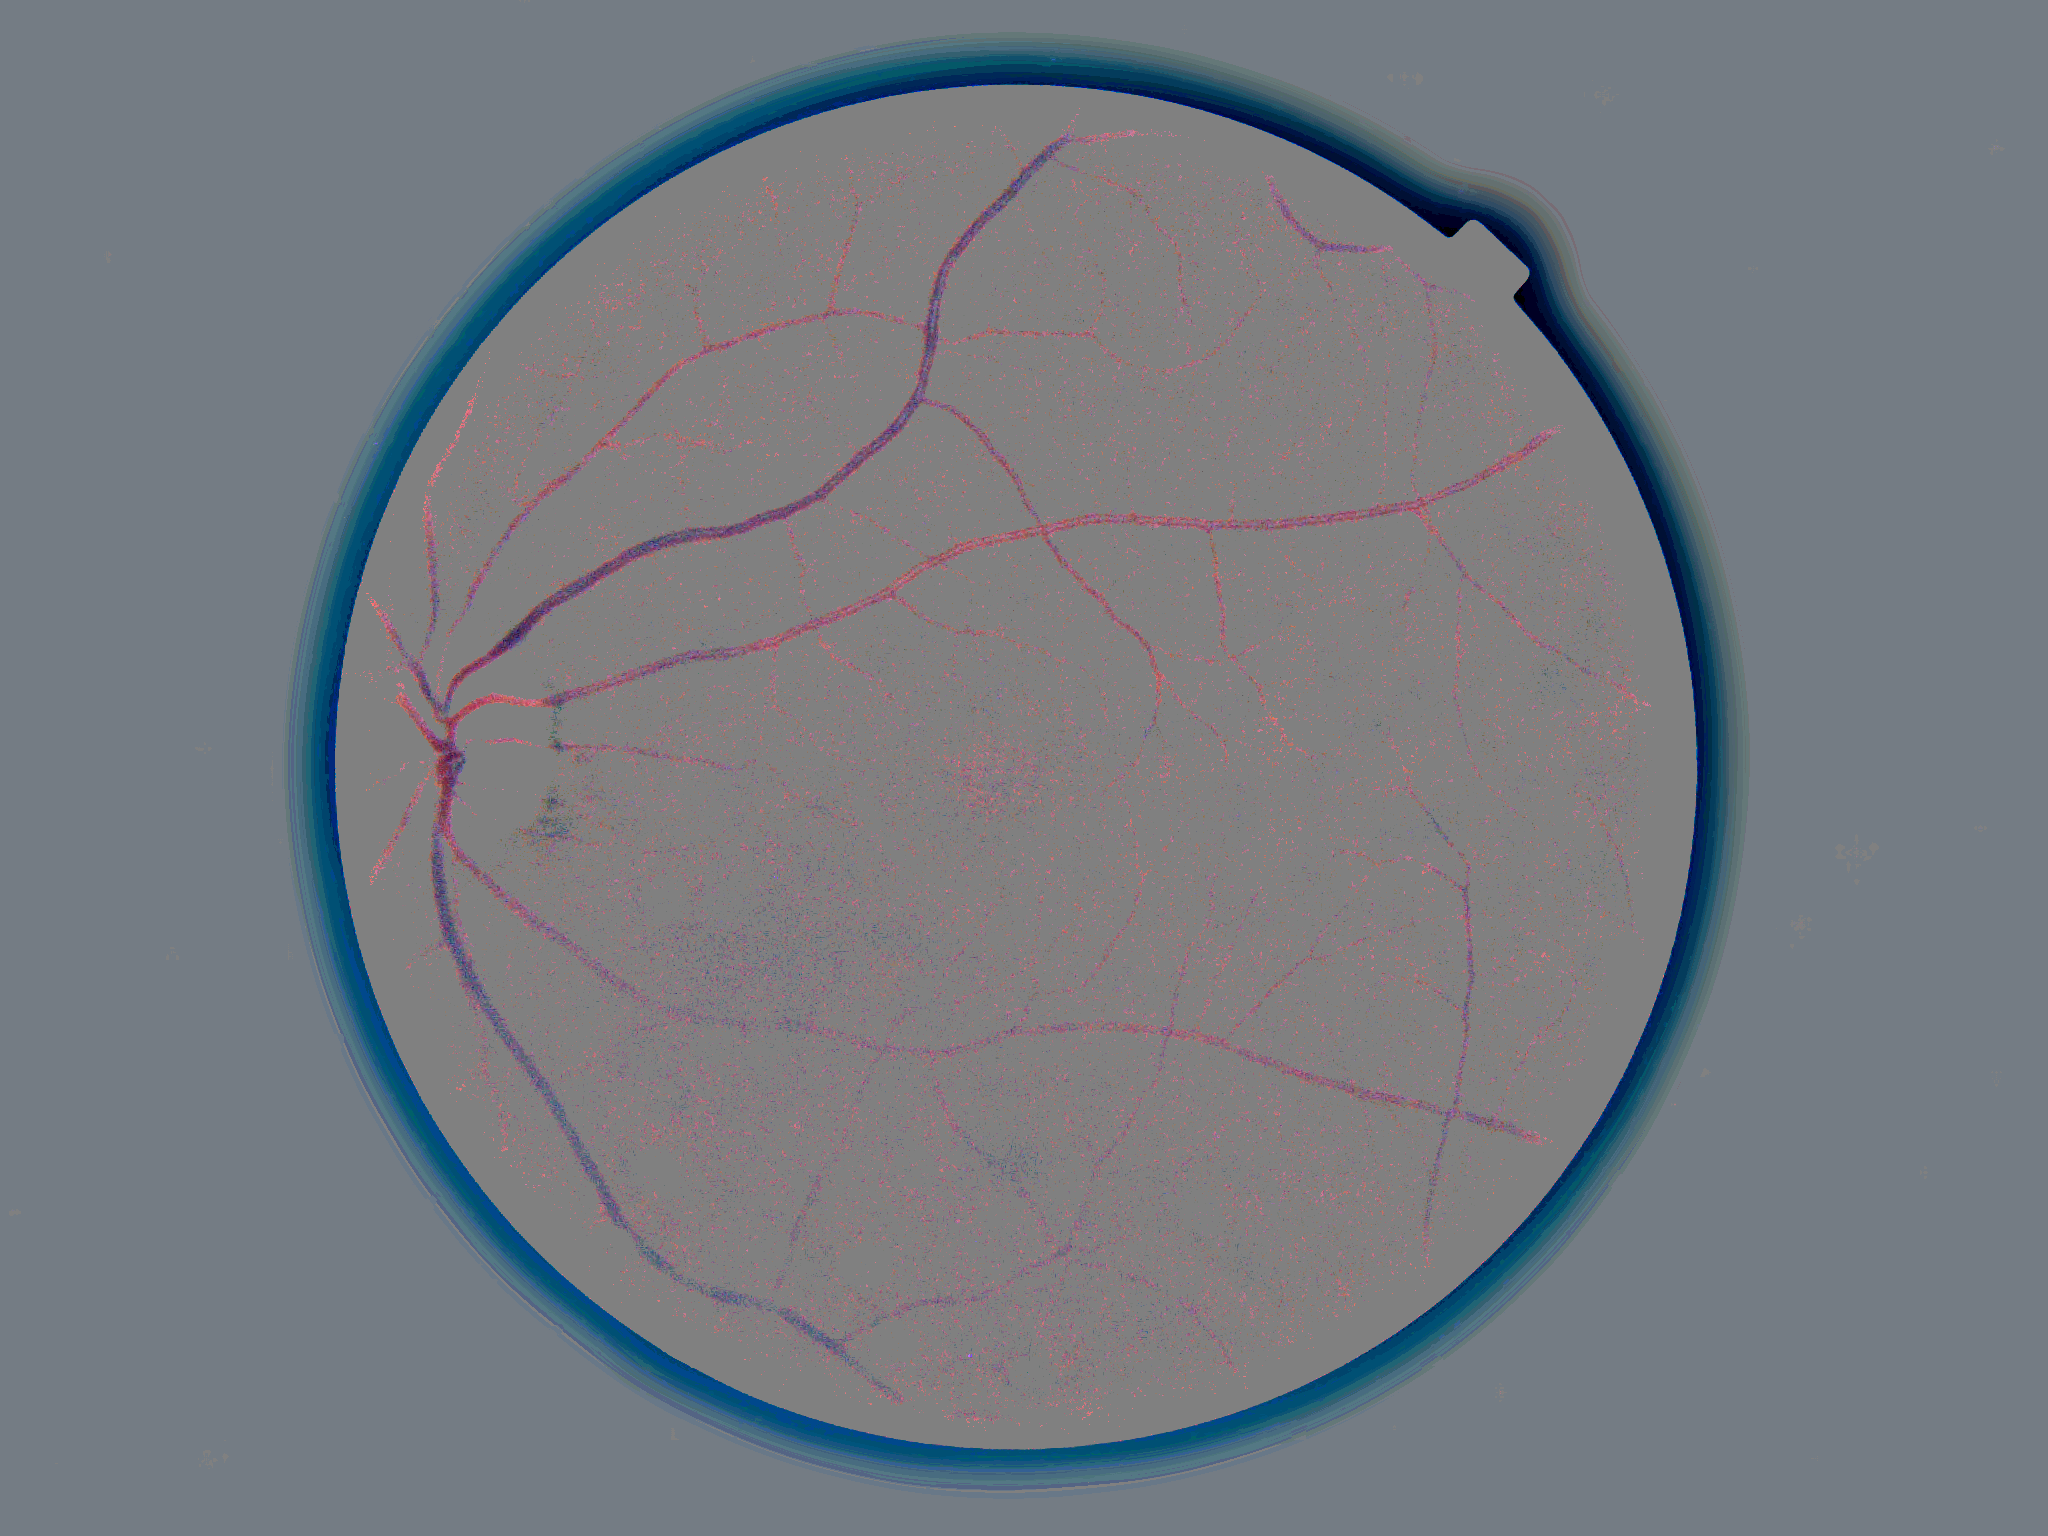

In [21]:
modified =  Fundus(modified.mask_torch(colors = toremove, replacement=np.array([[128,128,128]])), w=original.w, h=original.h)
modified.im

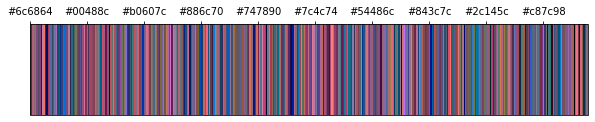

In [17]:
plot_color_bar(modified.palette)

In [ ]:
veinsubset =  Fundus(modified.im.crop((550, 550, 600, 600)))
print(len(veinsubset.palette))
veinsubset.im

In [ ]:
tohighlight = np.sort(veinsubset.palette, axis=0)[:50]
print(tohighlight.shape)

plot_color_bar(tohighlight)

In [ ]:
a = veinsubset.mask_torch(colors = tohighlight, replacement=np.array([[0,255,0]]))
fun = Fundus(a, w=veinsubset.w, h=veinsubset.h)

In [ ]:
fun.im

In [ ]:
fun.im.size